# Introduction

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1003,1,25.0,28800.0,1,0
2278,0,49.0,60300.0,1,2
1573,0,27.0,36600.0,2,0
3679,0,44.0,28900.0,0,1
2256,0,30.0,47900.0,1,0
462,1,19.0,46700.0,3,0
1168,1,31.0,38600.0,0,0
2930,0,21.0,39600.0,3,0
1632,0,31.0,38100.0,2,0
1097,1,29.0,46000.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# fix the age type (from float to int)
df['age'] = df['age'].astype(int)

In [7]:
# look at the data's descriptive statistics. 
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Descriptive statistics:

Gender - split 50/50 males/females

Age - mean age is close to median age, good distribution

Income - mean income again close to median income, good distribution

Family members - nothing looks out of order

Insurance benefits - possible issue here, majority did not claim insurance benefits, and we may not have enough 'positive' data

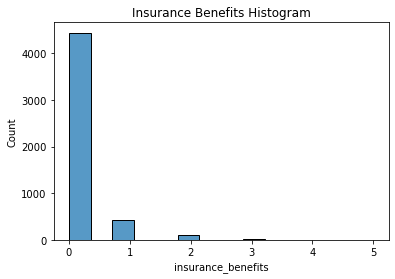

In [8]:
sns.histplot(data=df['insurance_benefits']).set(title='Insurance Benefits Histogram');

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

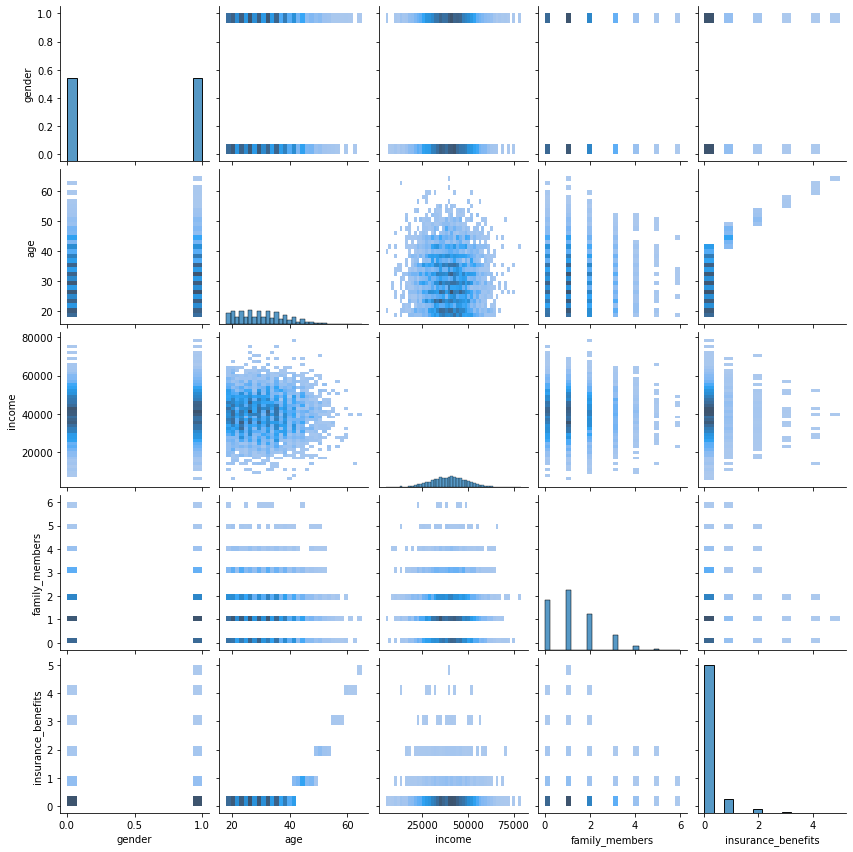

In [9]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler] scaler
- Distance Metrics
  - Euclidean
  - Manhattan

- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [13]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2494,1.0,0.646154,0.392405,0.000000,1
3628,0.0,0.307692,0.363291,0.166667,0
115,1.0,0.353846,0.417722,0.166667,0
3670,0.0,0.384615,0.464557,0.166667,0
1284,1.0,0.369231,0.402532,0.166667,0


Now, let's get similar records for a given one for every combination

In [14]:
# Constant values to test
n = 350 # object number
k = 6 # number of nearest neighbors
metric_eu = 'euclidean'
metric_ma = 'manhattan'

In [15]:
# No scaling, distance metric Euclidean
get_knn(df[feature_names], n, k, metric_eu)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
350,0,33,39700.0,0,0.000000
410,0,32,39700.0,1,1.414214
1253,1,34,39700.0,2,2.449490
995,0,28,39700.0,0,5.000000
955,1,28,39700.0,0,5.099020
4248,1,38,39700.0,1,5.196152


In [16]:
# Scaling, distance metric Euclidean
get_knn(df_scaled[feature_names], n, k, metric_eu)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
350,0.0,0.507692,0.502532,0.0,0.000000
4819,0.0,0.507692,0.496203,0.0,0.006329
4371,0.0,0.507692,0.510127,0.0,0.007595
2470,0.0,0.523077,0.505063,0.0,0.015592
1537,0.0,0.523077,0.505063,0.0,0.015592
4108,0.0,0.492308,0.498734,0.0,0.015846


In [17]:
# No scaling, distance metric Manhattan
get_knn(df[feature_names], n, k, metric_ma)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
350,0,33,39700.0,0,0.0
410,0,32,39700.0,1,2.0
1253,1,34,39700.0,2,4.0
995,0,28,39700.0,0,5.0
1704,0,39,39700.0,0,6.0
955,1,28,39700.0,0,6.0


In [18]:
# Scaling, distance metric Manhattan
get_knn(df_scaled[feature_names], n, k, metric_ma)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,distance
350,0.0,0.507692,0.502532,0.0,0.000000
4819,0.0,0.507692,0.496203,0.0,0.006329
4371,0.0,0.507692,0.510127,0.0,0.007595
2470,0.0,0.523077,0.505063,0.0,0.017916
1537,0.0,0.523077,0.505063,0.0,0.017916
4108,0.0,0.492308,0.498734,0.0,0.019182


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, scaling of the data appears to affect the kNN algorithm. The top 5 nearest neighbors are different if the data is scaled or not. Without scaling the data, the range in gender and ages are fairly wide, while it appears that the higher values (`income`) has a greater weight on the nearest neighbors. When the data is scaled, the customers appear to be more similar as all the values appear more similar to each other.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The rankings between using Manhattan or Euclidean distance metric are fairly similar. A majority of the same indices appear in the top 5 nearest neighbors when comparing between the two distance metrics.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [19]:
# calculate the target
df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 0 if x==0 else 1)

In [20]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

89% '0' and 11% '1'

In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [22]:
# generating output of a random model
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



Evaluating kNN based classifier on train/test 70/30 set on scaled/not scaled data

In [24]:
# Split training/testing 70/30
features_train, features_test, target_train, target_test = train_test_split( \
    df[feature_names], df['insurance_benefits_received'], test_size=0.3, random_state=12345)

In [25]:
# Confirm split
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3500, 4)
(1500, 4)
(3500,)
(1500,)


In [26]:
# Scaling data
scaler = sklearn.preprocessing.MaxAbsScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [27]:
# kNN based classifier n_neighers 1-10 on non-scaled vs scaled data
F1_scores = []
F1_scores_scaleddata = []
for k in range(1, 11):
    model_kNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_kNN_scaleddata = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')

    model_kNN.fit(features_train, target_train)
    model_kNN_scaleddata.fit(features_train_scaled, target_train)

    predictions = model_kNN.predict(features_test)
    predictions_scaleddata = model_kNN_scaleddata.predict(features_test_scaled)

    # Output metrics for kNN classifier
    print(f'For n_neighbors = {k}')
    print('Non-scaled data')
    eval_classifier(target_test, predictions)
    print()
    print('Scaled data')
    eval_classifier(target_test, predictions_scaleddata)
    print()
    
    # Store F1 metric
    f1_score = sklearn.metrics.f1_score(target_test, predictions)
    f1_score_scaleddata = sklearn.metrics.f1_score(target_test, predictions_scaleddata)
    F1_scores.append(f1_score)
    F1_scores_scaleddata.append(f1_score_scaleddata)

For n_neighbors = 1
Non-scaled data
F1: 0.60
Confusion Matrix
[[0.87066667 0.02066667]
 [0.05266667 0.056     ]]

Scaled data
F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

For n_neighbors = 2
Non-scaled data
F1: 0.41
Confusion Matrix
[[0.88733333 0.004     ]
 [0.08       0.02866667]]

Scaled data
F1: 0.93
Confusion Matrix
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]

For n_neighbors = 3
Non-scaled data
F1: 0.41
Confusion Matrix
[[0.87933333 0.012     ]
 [0.078      0.03066667]]

Scaled data
F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]

For n_neighbors = 4
Non-scaled data
F1: 0.28
Confusion Matrix
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]

Scaled data
F1: 0.91
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]

For n_neighbors = 5
Non-scaled data
F1: 0.27
Confusion Matrix
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]

Scaled data
F1: 0.92
Confusion Matrix
[[0.88666667 0.0

    F1_nonscaled-data  F1_scaleddata
1            0.604317       0.965944
2            0.405660       0.928105
3            0.405286       0.949367
4            0.278351       0.907895
5            0.271357       0.924051
6            0.114286       0.903654
7            0.112994       0.920128
8            0.071006       0.901316
9            0.082353       0.915584
10           0.000000       0.879195


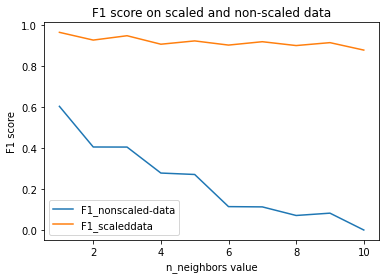

In [28]:
# Generate dataframe and plot of results
df_kNN_f1scores = pd.DataFrame(data=F1_scores, columns=['F1_nonscaled-data'], index=range(1,11))
df_kNN_f1scores['F1_scaleddata'] = F1_scores_scaleddata
print(df_kNN_f1scores)

plot = sns.lineplot(data=df_kNN_f1scores, dashes=False)
plot.set(title='F1 score on scaled and non-scaled data')
plot.set(xlabel='n_neighbors value', ylabel='F1 score');

Scaling the data makes a huge difference. As the number of neighbors to use increases, the F1 metric for non-scaled data decreases, while the F1 score for scaled data remains relatively constant. Huge improvement with kNN classifer model on the scaled data.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [29]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [30]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [33]:
# Non-scaled data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


In [34]:
# Scaled data
scaler = sklearn.preprocessing.MaxAbsScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

RMSE: 0.34
R2: 0.66


Both the RMSE and R2 score for scaled and non-scaled data are the same using linear regression!

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

In [35]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [36]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [38]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

P is invertible since the matrix can be inversed (i.e. no error when running np.linalg.inv())

Can you guess the customers' ages or income after the transformation?

In [39]:
X_prime = X @ P
print(X_prime)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


Nope, cannot guess any of the personal information after transformation.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one.

$$
X' = X \times P
$$
Multiply $P^{-1}$ to both sides:
$$
X' \times P^{-1} = X \times P \times P^{-1}
$$
$P$ $\times$ $P^{-1}$ = $I$ (identity matrix), thus:
$$
X' \times P^{-1} = X
$$

In [40]:
X_recovered = X_prime @ np.linalg.inv(P)

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [41]:
print(f'Original data:\n {X}')
print()
print(f'Transformed data:\n {X_prime}')
print()
print(f'Recovered data:\n {X_recovered}')

Original data:
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Transformed data:
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Recovered data:
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-3.18323146e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [ 1.36424205e-12  2.90000000e+01  2.10000000e+04  0.00000000e+00]
 ...
 [ 4.54747351e-13  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

When the matrix is inversed, the resulting values may not be exact and rounded to some decimal position. When the values are recovered, then the recovered values will not be exactly the same.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Let's prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same.

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

**Answer**

The predicted values with $w_p$ shows to be the same where $\hat{y}_p = y$. Meaning the prediction from the obfuscated data is the same as the predictions from the un-masked data. Because the predictions are the same, the RMSE will be the same.

**Analytical proof**

$$
y = Xw
$$
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T Xw
$$
$$
w_P = [(P^TX^T) (XP)]^{-1} P^TX^T Xw \quad \Rightarrow \quad w_P = (XP)^{-1}(P^TX^T)^{-1}  P^TX^T Xw
$$
$$
w_P = P^{-1}X^{-1}{X^T}^{-1}{P^T}^{-1}  P^TX^T Xw \quad \Rightarrow \quad w_P = P^{-1}X^{-1}{X^T}^{-1}X^T Xw
$$
$$
w_P = P^{-1}w
$$
$$
P w_p = w
$$

The formula to calculate predicted values with $w_p$ in the obfuscated data is:

$$
\hat{y}_p = (XP)w_p
$$

Substitute $w_p = P^{-1}w$

$$
\hat{y}_p = XPP^{-1}w
$$
$$
\hat{y}_p = Xw
$$

Thus, $\hat{y}_p = Xw = y$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix
- Split training/testing 70/30 and compare between $X$ and $XP$ features

In [42]:
# Make original data
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
X = df_pn.to_numpy()
y = df['insurance_benefits'].to_numpy()

In [43]:
# Generate random matrix P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
# Check if P is invertible
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [44]:
# Make obfuscated data
X_obf = X @ P

In [45]:
# Confirm data obfuscation
print(f'Non-obfuscated data:\n {X}')
print()
print(f'Obfuscated data:\n {X_obf}')

Non-obfuscated data:
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Obfuscated data:
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


In [46]:
# Evaluate linear regression model on non-obfuscated data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)

eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


In [47]:
# Evaluate linear regression model on obfuscated data
X_train_obf, X_test_obf, y_train_obf, y_test_obf = train_test_split(X_obf, y, test_size=0.3, random_state=12345)

lr_obf = MyLinearRegression()
lr_obf.fit(X_train_obf, y_train_obf)

y_test_pred_obf = lr_obf.predict(X_test_obf)

eval_regressor(y_test_obf, y_test_pred_obf)

RMSE: 0.34
R2: 0.66


No difference between the RMSE and R2 score of obfuscated features and non-obfuscated features. They are the same!

# Conclusions

We have explored the use of k-Nearest Neighbor to find customers that are similar to one another. The analysis shows that to get a better result, the features need to be scaled or else certain features are weighted differently due to its values. Furthermore, the effects of the distance metric between Euclidean or Manhattan has very little effect on the results.

Next, we trained a kNN classifier model to predict whether a person will receive insurance benefits or not. Again, scaling the features is critically important, as the trained model resulted in a F1 score of 0.92, compared to a dummy model (binomial random prediction) F1 score of 0.20.

Linear regression model can be used to predict the number of insurance benefits. In this case, we show that the features does not need to be scaled as the resulting predictions had the same RMSE and R2 metrics with and without scaling.

Finally, we show that personal information data can be obfuscated by multiplying the features with an invertible matrix. The resulting information can be recovered, and that linear regression model can be used on both the obfuscated and non-obfuscated data with no issues. 

## Appendix: Properties of Matrices

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>